# Solution proposal - Support Vector Machines

INF4300 - Digital Image Analysis
<br>
Ole-Johan Skrede
<br>
University of Oslo
<br>
October 2017

## Task 2

First, let us define the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

X_0 = np.array([[1, 9], [5, 5], [1, 1]])
X_1 = np.array([[8, 5], [13, 1], [13, 9]])

# Concatenate them and provide an extra label vector
X = np.vstack((X_0, X_1))
Y = np.array([0, 0, 0, 1, 1, 1])

Then, we create a scatter plot function that will be used throughout this exercise.

In [2]:
def make_meshgrid(X, h=.02, x_range=None, y_range=None):
    """Make a meshgrid covering the range of X. This is used to display classification regions.
    
    Args:
        X: numpy array of shape [n, 2] containing n 2d feature vectors
        h: parameter controlling the resolution of the 
    """
    if x_range is None:
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    else:
        x_min, x_max = x_range
    if y_range is None:
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    else:
        y_min, y_max = y_range
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def scatter(X, Y, xx=None, yy=None, Z=None, plot_mean=False, x_range=None, y_range=None):
    """
    Scatter plot with optional classification area and mean plot
        
    Args:
        X: numpy array of shape [n, 2] where n is the total number of datapoints
        Y: numpy array of shape [n] containing the labels {1, 2, 3, ...} of X
        xx: meshgrid x
        yy: meshgrid y
        Z: The result of applying some prediction function on all points in xx and yy
    """
    #import seaborn as sns
    #current_palette = sns.color_palette("muted", n_colors=5)
    #cmap = ListedColormap(sns.color_palette(current_palette).as_hex())
    cmap=plt.cm.coolwarm
    
    if x_range is None:
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    else:
        x_min, x_max = x_range
    if y_range is None:
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    else:
        y_min, y_max = y_range
    plt.figure(figsize=(10, 10))
    if xx is not None and yy is not None and Z is not None:
        # Color class regions
        plt.gca().contourf(xx, yy, Z, cmap=cmap, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap, marker='o', edgecolors='k')
    if plot_mean:
        mean_0 = np.mean(X[Y == 0], axis=0)
        mean_1 = np.mean(X[Y == 1], axis=0)
        plt.scatter(mean_0[0], mean_0[1], c='cyan', cmap=cmap, marker='x')
        plt.scatter(mean_1[0], mean_1[1], c='magenta', cmap=cmap, marker='x')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.axes().set_aspect('equal')

    plt.show()

In this case, the decision boundary will be the vertical line segment at $x = 6.5.$ The support vectors will be the data points closest to the decision boundary, namely $(5, 5)$ for Class 0 and $(8, 5)$ for Class 1.

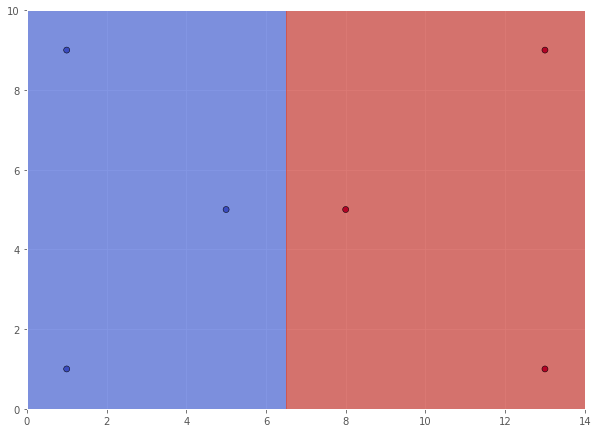

In [3]:
# Create a meshgrid of our domain
xx, yy = make_meshgrid(X)
# Define our class regions according to the decision boundary above
Z = (xx > 6.5)*1.0
scatter(X, Y, xx, yy, Z)

## Task 3

### a)

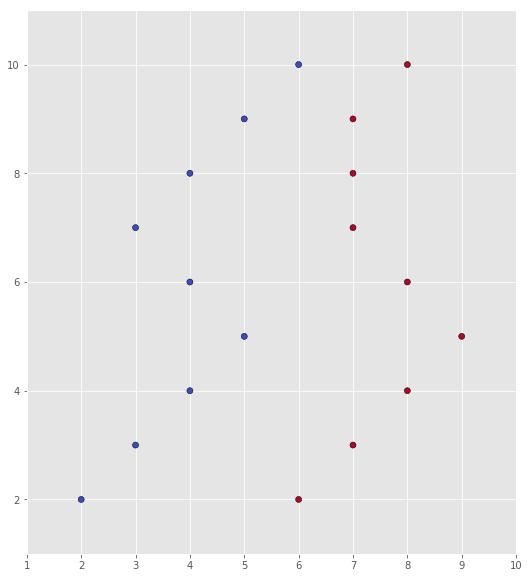

In [4]:
X = np.array([[2, 2], [3, 3], [4, 4], [5, 5], [4, 6], [3, 7], [4, 8], [5, 9], [6, 10],
              [6, 2], [7, 3], [8, 4], [9, 5], [8, 6], [7, 7], [7, 8], [7, 9], [8, 10]])
Y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])
scatter(X, Y)

### b)

In the case of a Gaussian classifier with a scalar identity covariance matrix, the decision boundary (assuming equal priors) would be the line equidistant to the two class means, and normal on the line segment joining the two means. So, let us create a function that compute this line segment.

In [5]:
def compute_normal(X, Y):
    """
    Computes the line consisting of points equidistant from the means
    of data_0 and data_1.
    
    A line (x, y) through a point (x0, y0) and normal to the line given by
    the vector v = [a, b] will obey the following equation
    
    a(x - x0) + b(y - y0) = 0.
    
    In this case, the vector between the mean points is our normal vector,
    and the point it should pass through is the average between the means.
    """
    X_0 = X[Y == 0]
    X_1 = X[Y == 1]
    mean_0 = np.mean(X_0, axis=0)
    mean_1 = np.mean(X_1, axis=0)
    avg_01 = [(mean_0[0] + mean_1[0])/2, (mean_0[1] + mean_1[1])/2]
    
    # Compute min and max for x, mostly for plotting reasons
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Compute the line equidistant to both means
    if mean_0[1] == mean_0[1]: # Vertical decision boundary
        x = [avg_01[0] for _ in range(y_min, y_max)]
        y = [i for i in range(y_min, y_max)]
    else:
        x = np.linspace(x_min, x_max)
        y = avg_01[1] - (mean_1[0] - mean_0[0])/(mean_1[1] - mean_0[1])*(x - avg_01[0])
    
    return np.column_stack((x, y))

Now, we can use this function to plot the mean values together with the decision boundary.

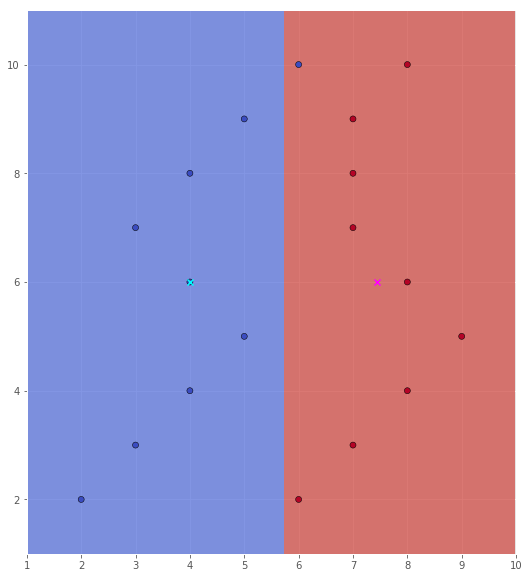

In [6]:
decision_boundary = compute_normal(X, Y)
# In this case, the decision boundary happens to also be vertical
xx, yy = make_meshgrid(X)
Z = (xx > decision_boundary[0, 0])*1.0
scatter(X, Y, xx, yy, Z, plot_mean=True)

### c)

We see that we classify one datapoint from Class 1 as Class 2, and since we have 18 data points in total, this would be an error rate of $1 / 18$ or about $5.6\%$.

### d)

In this case, we can see (by inspection of the scatter plot) that the support vectors are $(5, 5)$, $(6, 10)$, $(7, 9)$. In order to draw the classification area, I use the `svm` module from the `sklearn` library. We will explore this library further below, so no explanation is given here.

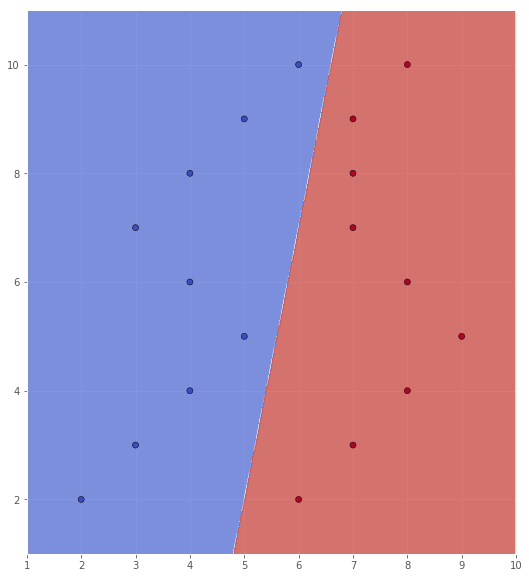

In [7]:
from sklearn import svm

classifier = svm.SVC(C=100.0, kernel='linear')
classifier.fit(X, Y)

xx, yy = make_meshgrid(X)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X, Y, xx, yy, Z)

### e)

As we can see, the SVM classifies the training set with an error rate of 0.

## Task 4

Assuming that we have downloaded the data and put it in a reasonable location, we can take a look at it.

### a)

In [8]:
## Load the data

import scipy.io

normaldistdata = scipy.io.loadmat('../../images/mynormaldistdataset.mat')
print("Normaldistdata keys: ", normaldistdata.keys())
bananadata = scipy.io.loadmat('../../images/mybananadataset.mat')
print("Bananadata keys: ", bananadata.keys())

Normaldistdata keys:  dict_keys(['A', '__version__', '__header__', '__globals__', 'a'])
Bananadata keys:  dict_keys(['__version__', 'A', 'B', 'a', '__header__', '__globals__', 'b'])


In this case, `A` contains data points and `a` contains corresponding labels. Similarly, `b` contains the labels for the data in `B`.

First, let us look at the data in `normaldistdata`.

Number of datapoints in class 0:  100
Number of datapoints in class 1:  100


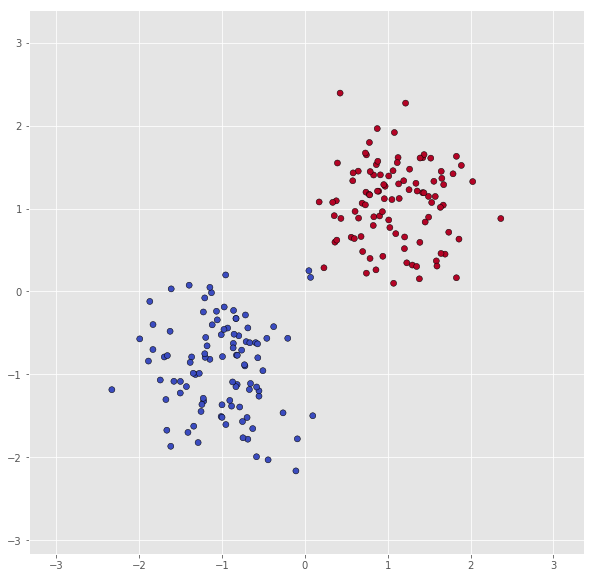

In [9]:
X = normaldistdata['A']
Y = np.squeeze(normaldistdata['a'])

print("Number of datapoints in class 0: ", len(X[Y == 0]))
print("Number of datapoints in class 1: ", len(X[Y == 1]))

scatter(X, Y)

Then, dataset `A` in `mybananadataset`

Number of datapoints in class 0:  94
Number of datapoints in class 1:  106


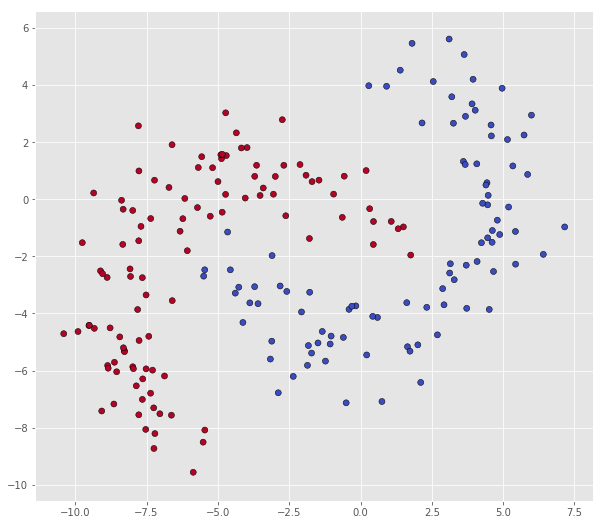

In [10]:
X = bananadata['A']
Y = np.squeeze(bananadata['a'])

print("Number of datapoints in class 0: ", len(X[Y == 0]))
print("Number of datapoints in class 1: ", len(X[Y == 1]))

scatter(X, Y)

And finally, dataset `B` in `mybananadataset`

Number of datapoints in class 0:  94
Number of datapoints in class 1:  106


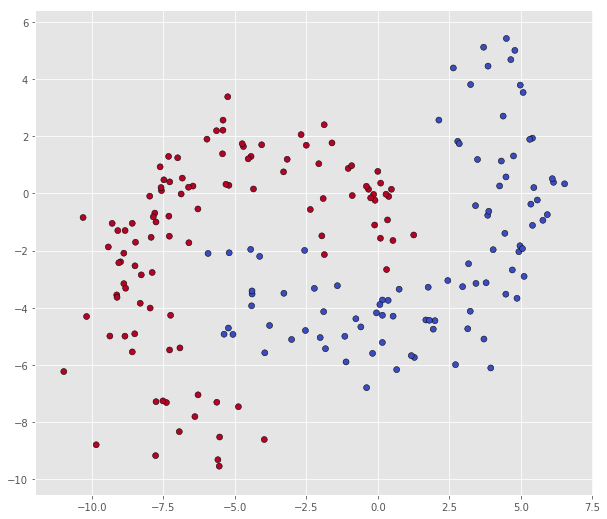

In [11]:
X = bananadata['B']
Y = np.squeeze(bananadata['b'])

print("Number of datapoints in class 0: ", len(X[Y == 0]))
print("Number of datapoints in class 1: ", len(X[Y == 1]))

scatter(X, Y)

### b)

First, we create some functions that we can use to evaluate the results

In [12]:
from collections import defaultdict

def evaluate(reference, proposal):
    """Compute evaluation metrics based on the confusion matrix of the proposed labeling,
    given a reference labeling.
    
    Confusion matrix relative to class 1:
    
                         PROPOSAL
                class    0      1
    REFERENCE     0      TN     FP
                  1      FN     TP
    
    Note that in a multilabel (> 2) case, it would be useful to compute a metric for each label. In the binary
    case, we can do it simpler by just naming label 1 as positive and label 0 as negative, and get one
    value for each metric.
    """
    num_classes = 2
    cm = np.zeros((num_classes, num_classes))
    for i, ref_val in enumerate(reference):
        prop_val = proposal[i]
        cm[ref_val, prop_val] += 1
            
    metrics = defaultdict(list)
    for c in range(num_classes):
        metrics['TP'].append(cm[c, c]) # True positive
        metrics['FP'].append(np.sum(cm[:, c]) - metrics['TP'][c]) # False positive
        metrics['FN'].append(np.sum(cm[c, :]) - metrics['TP'][c]) # False negative
        metrics['TN'].append(np.sum(cm) - metrics['TP'][c] - metrics['FN'][c] - metrics['FP'][c]) # True negative
        
        # Sensitivity
        if metrics['FN'][c] + metrics['TP'][c] > 0:
            metrics['tpr'].append(metrics['TP'][c] / (metrics['FN'][c] + metrics['TP'][c]))
        else:
            metrics['tpr'].append(0.0)
        # Specificity
        if metrics['FP'][c] + metrics['TN'][c] > 0:
            metrics['tnr'].append(metrics['TN'][c] / (metrics['FP'][c] + metrics['TN'][c]))
        else:
            metrics['tnr'].append(0.0)
        # Precision
        if metrics['FP'][c] + metrics['TP'][c] > 0:
            metrics['ppv'].append(metrics['TP'][c] / (metrics['FP'][c] + metrics['TP'][c]))
        else:
            metrics['ppv'].append(0.0)
        # Accuracy
        if np.sum(cm) > 0:
            metrics['acc'].append((metrics['TP'][c] + metrics['TN'][c]) / np.sum(cm))
        else:
            metrics['acc'].append(0.0)
    return metrics

def average_metrics(list_of_metrics):
    """Average list of metrics."""
    sum_metrics = {}
    for metrics in list_of_metrics:
        for key, metric in metrics.items():
            if key in sum_metrics.keys():
                sum_metrics[key] += np.array(metric)
            else:
                sum_metrics[key] = np.array(metric)
    avg_metrics = {}         
    for key, val in sum_metrics.items():
        avg_metrics[key] = val / len(list_of_metrics)
    return avg_metrics

def pretty_print(metrics):
    """Print metrics in a table"""
    print_header = True
    for name, values in sorted(metrics.items()):
        if print_header:
            printstr = "{0:<20} ".format("Metric name")
            for i, _ in enumerate(values):
                printstr += "Label {0:<2} ".format(i)
            printstr += "Average"
            print_header = False
            print(printstr)
        printstr = "{0:<20} ".format(name)
        for val in values:
            printstr += "{0:>8,.3f} ".format(val)
        printstr += "{0:>8,.3f}".format(np.mean(values))
        print(printstr)

Now, we can start to explore the `svm` module.

In [13]:
from sklearn import svm

X = normaldistdata['A']
Y = np.squeeze(normaldistdata['a'])

classifier = svm.SVC()
classifier.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

The model is now trained on the data, with the default hyperparameter values listed above. We can use this to classify new data points.

In [14]:
print("Point (1, 2) is predicted to have label", classifier.predict([[1, 2]]))

Point (1, 2) is predicted to have label [1]


The parameters we care about in this task are `C`, `kernel`, and `gamma`. In this subtask we shall use a linear kernel, and various values of $C$. Let us try with $C = 1$ first.

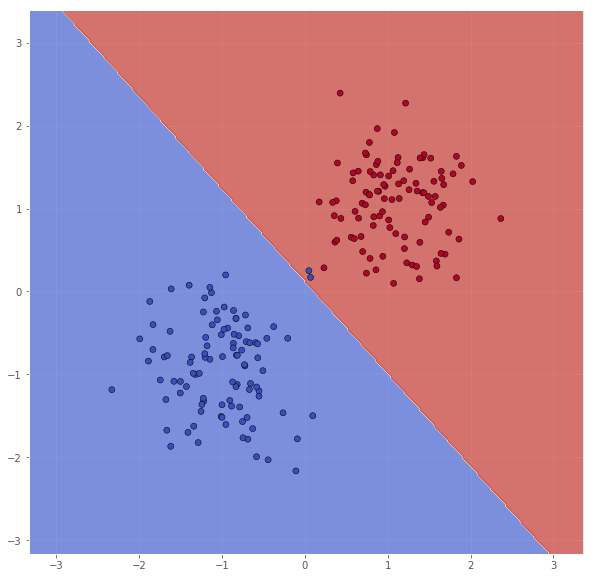

Metric name          Label 0  Label 1  Average
FN                      2.000    0.000    1.000
FP                      0.000    2.000    1.000
TN                    100.000   98.000   99.000
TP                     98.000  100.000   99.000
acc                     0.990    0.990    0.990
ppv                     1.000    0.980    0.990
tnr                     1.000    0.980    0.990
tpr                     0.980    1.000    0.990


In [15]:
classifier = svm.SVC(C=1.0, kernel='linear')
classifier.fit(X, Y)

xx, yy = make_meshgrid(X)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X, Y, xx, yy, Z)
pretty_print(evaluate(Y, classifier.predict(X)))

It seems like some of the outliers are missclassified. By increasing $C$, we can enforce stricter regularization, and try to leviate this.

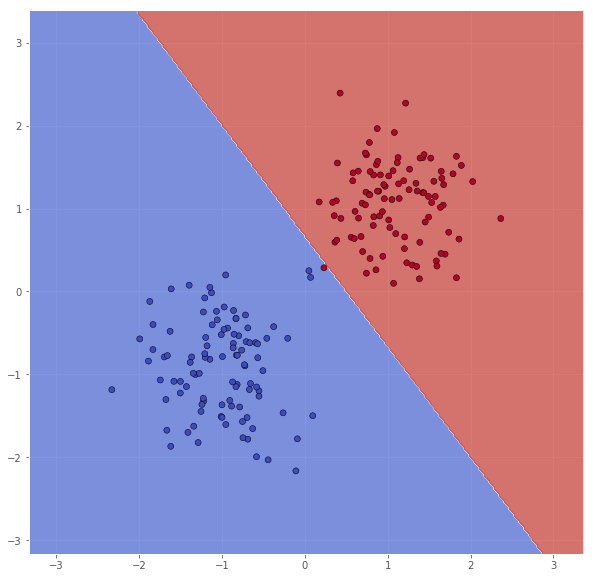

Metric name          Label 0  Label 1  Average
FN                      0.000    1.000    0.500
FP                      1.000    0.000    0.500
TN                     99.000  100.000   99.500
TP                    100.000   99.000   99.500
acc                     0.995    0.995    0.995
ppv                     0.990    1.000    0.995
tnr                     0.990    1.000    0.995
tpr                     1.000    0.990    0.995


In [16]:
classifier = svm.SVC(C=10.0, kernel='linear')
classifier.fit(X, Y)

xx, yy = make_meshgrid(X)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X, Y, xx, yy, Z)
pretty_print(evaluate(Y, classifier.predict(X)))

This is better, but it still seems like some of the outliers, now from the other class, are missclassified. We will try to increase $C$ once more.

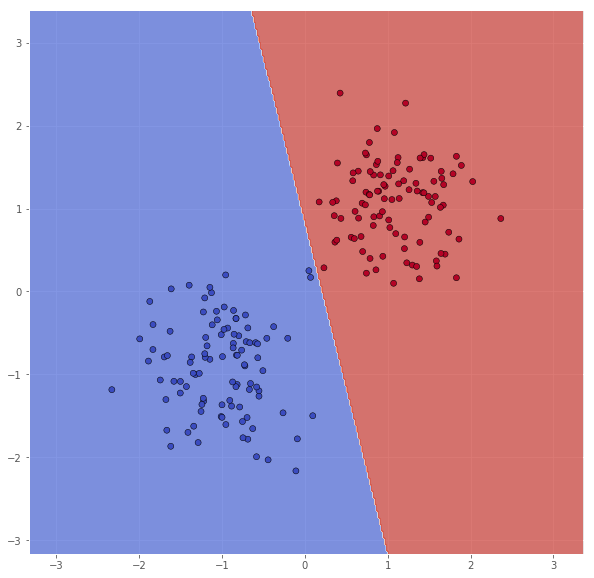

Metric name          Label 0  Label 1  Average
FN                      0.000    0.000    0.000
FP                      0.000    0.000    0.000
TN                    100.000  100.000  100.000
TP                    100.000  100.000  100.000
acc                     1.000    1.000    1.000
ppv                     1.000    1.000    1.000
tnr                     1.000    1.000    1.000
tpr                     1.000    1.000    1.000


In [17]:
classifier = svm.SVC(C=100.0, kernel='linear')
classifier.fit(X, Y)

xx, yy = make_meshgrid(X)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X, Y, xx, yy, Z)
pretty_print(evaluate(Y, classifier.predict(X)))

We now are able to classify the training set perfectly.

### c)

The classifier also gives information about the support vectors.

In [18]:
print("Support vectors: ", classifier.support_vectors_)
print("Support vector indices: ", classifier.support_)
print("Number of support vectors for class 0 and class respectively: ", classifier.n_support_)

Support vectors:  [[ 0.07008741  0.16943029]
 [ 0.05        0.25      ]
 [ 0.2316275   0.28493687]]
Support vector indices:  [114 199  39]
Number of support vectors for class 0 and class respectively:  [2 1]


So, we can try to remove some vectors which indices are not `[114, 199, 39]`.

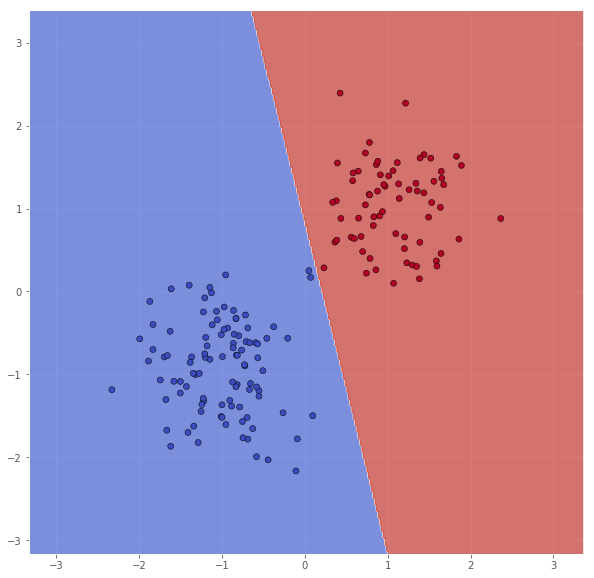

Metric name          Label 0  Label 1  Average
FN                      0.000    0.000    0.000
FP                      0.000    0.000    0.000
TN                     70.000  100.000   85.000
TP                    100.000   70.000   85.000
acc                     1.000    1.000    1.000
ppv                     1.000    1.000    1.000
tnr                     1.000    1.000    1.000
tpr                     1.000    1.000    1.000


In [19]:
X_sub = X[30:, :]
Y_sub = Y[30:]
classifier = svm.SVC(C=100.0, kernel='linear')
classifier.fit(X_sub, Y_sub)

xx, yy = make_meshgrid(X_sub)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X_sub, Y_sub, xx, yy, Z)
pretty_print(evaluate(Y_sub, classifier.predict(X_sub)))

As expected, removing non-support vectors did not change the decision boundary, but let us try removing all except the support vectors.

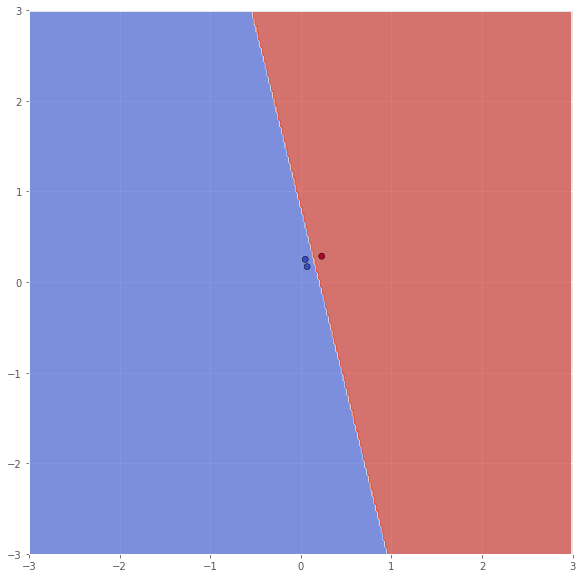

Metric name          Label 0  Label 1  Average
FN                      0.000    0.000    0.000
FP                      0.000    0.000    0.000
TN                      1.000    2.000    1.500
TP                      2.000    1.000    1.500
acc                     1.000    1.000    1.000
ppv                     1.000    1.000    1.000
tnr                     1.000    1.000    1.000
tpr                     1.000    1.000    1.000


In [20]:
X_sub = np.array([X[114, :], X[199, :], X[39, :]])
Y_sub = np.array([Y[114], Y[199], Y[39]])
classifier = svm.SVC(C=100.0, kernel='linear')
classifier.fit(X_sub, Y_sub)

xx, yy = make_meshgrid(X_sub, x_range=(-3, 3), y_range=(-3, 3))
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X_sub, Y_sub, xx, yy, Z, x_range=(-3, 3), y_range=(-3, 3))
pretty_print(evaluate(Y_sub, classifier.predict(X_sub)))

### d)

As we see below, the linear svm does a decent job of separating the features, but is of course unable to get a perfect fit on this data.

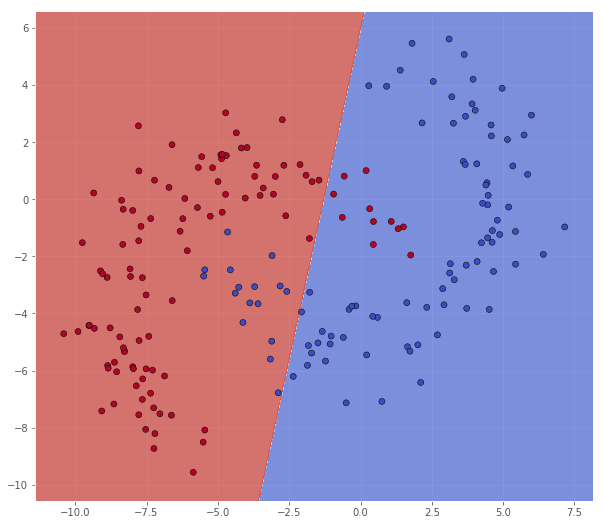

Metric name          Label 0  Label 1  Average
FN                     16.000   11.000   13.500
FP                     11.000   16.000   13.500
TN                     95.000   78.000   86.500
TP                     78.000   95.000   86.500
acc                     0.865    0.865    0.865
ppv                     0.876    0.856    0.866
tnr                     0.896    0.830    0.863
tpr                     0.830    0.896    0.863


In [21]:
X = bananadata['A']
Y = np.squeeze(bananadata['a'])

classifier = svm.SVC(C=0.001, kernel='linear')
classifier.fit(X, Y)
xx, yy = make_meshgrid(X)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X, Y, xx, yy, Z)
pretty_print(evaluate(Y, classifier.predict(X)))

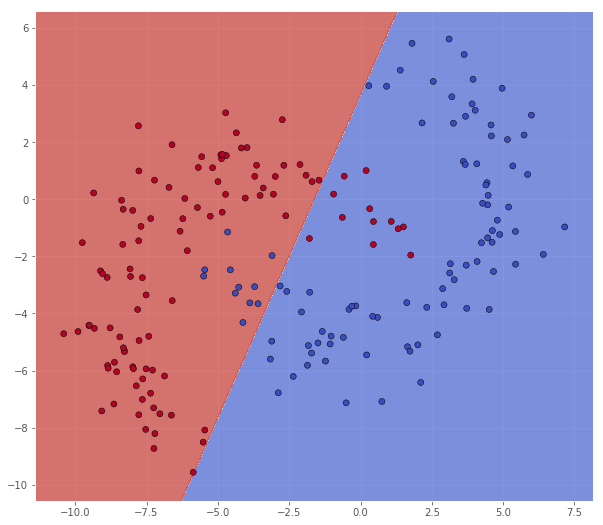

Metric name          Label 0  Label 1  Average
FN                     11.000   12.000   11.500
FP                     12.000   11.000   11.500
TN                     94.000   83.000   88.500
TP                     83.000   94.000   88.500
acc                     0.885    0.885    0.885
ppv                     0.874    0.895    0.884
tnr                     0.887    0.883    0.885
tpr                     0.883    0.887    0.885


In [22]:
classifier = svm.SVC(C=0.1, kernel='linear')
classifier.fit(X, Y)
xx, yy = make_meshgrid(X)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X, Y, xx, yy, Z)
pretty_print(evaluate(Y, classifier.predict(X)))

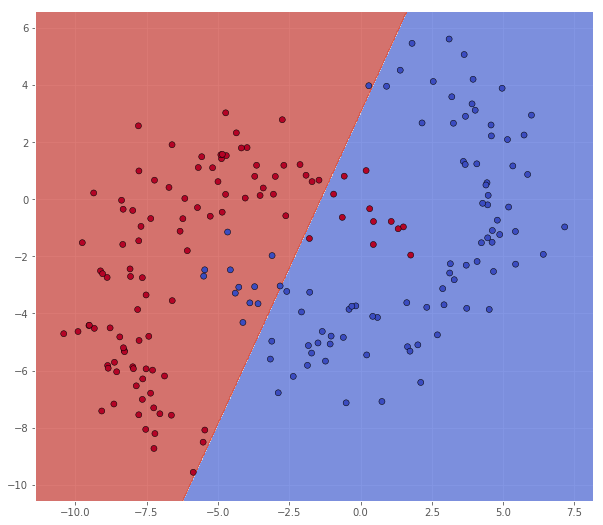

Metric name          Label 0  Label 1  Average
FN                     13.000   12.000   12.500
FP                     12.000   13.000   12.500
TN                     94.000   81.000   87.500
TP                     81.000   94.000   87.500
acc                     0.875    0.875    0.875
ppv                     0.871    0.879    0.875
tnr                     0.887    0.862    0.874
tpr                     0.862    0.887    0.874


In [23]:
classifier = svm.SVC(C=10.0, kernel='linear')
classifier.fit(X, Y)
xx, yy = make_meshgrid(X)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X, Y, xx, yy, Z)
pretty_print(evaluate(Y, classifier.predict(X)))

### e)

Lets try some different values. The default value seems to be okay.

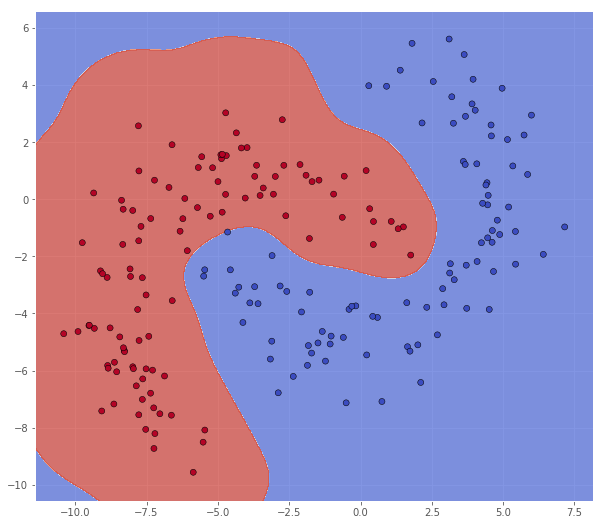

Metric name          Label 0  Label 1  Average
FN                      0.000    0.000    0.000
FP                      0.000    0.000    0.000
TN                    106.000   94.000  100.000
TP                     94.000  106.000  100.000
acc                     1.000    1.000    1.000
ppv                     1.000    1.000    1.000
tnr                     1.000    1.000    1.000
tpr                     1.000    1.000    1.000


In [24]:
num_features = 2
classifier = svm.SVC(C=1.0, kernel='rbf', gamma=1/num_features) # This is the default gamma
classifier.fit(X, Y)
xx, yy = make_meshgrid(X)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X, Y, xx, yy, Z)
pretty_print(evaluate(Y, classifier.predict(X)))

Reducing this seems to underfit the data

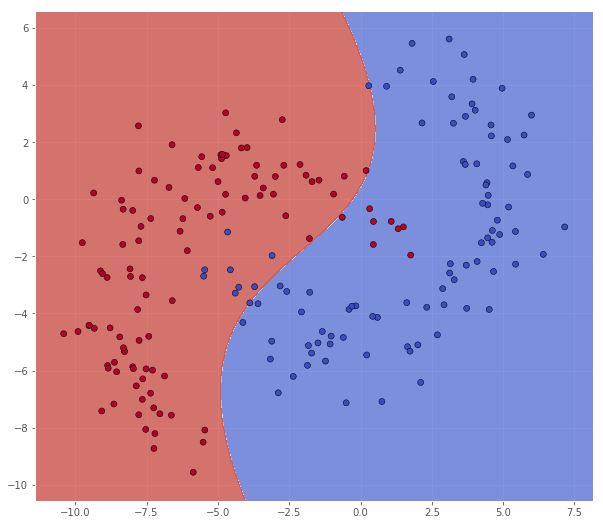

Metric name          Label 0  Label 1  Average
FN                      9.000    8.000    8.500
FP                      8.000    9.000    8.500
TN                     98.000   85.000   91.500
TP                     85.000   98.000   91.500
acc                     0.915    0.915    0.915
ppv                     0.914    0.916    0.915
tnr                     0.925    0.904    0.914
tpr                     0.904    0.925    0.914


In [25]:
classifier = svm.SVC(C=1.0, kernel='rbf', gamma=1e-2)
classifier.fit(X, Y)
xx, yy = make_meshgrid(X)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X, Y, xx, yy, Z)
pretty_print(evaluate(Y, classifier.predict(X)))

While increasing it seems to overfit

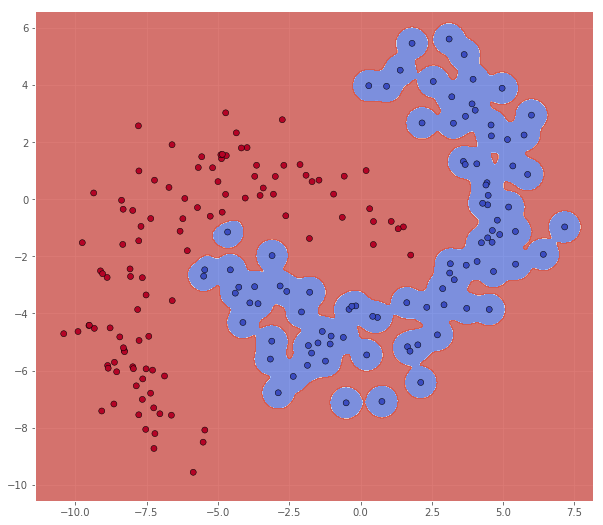

Metric name          Label 0  Label 1  Average
FN                      0.000    0.000    0.000
FP                      0.000    0.000    0.000
TN                    106.000   94.000  100.000
TP                     94.000  106.000  100.000
acc                     1.000    1.000    1.000
ppv                     1.000    1.000    1.000
tnr                     1.000    1.000    1.000
tpr                     1.000    1.000    1.000


In [26]:
classifier = svm.SVC(C=1.0, kernel='rbf', gamma=10)
classifier.fit(X, Y)
xx, yy = make_meshgrid(X)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X, Y, xx, yy, Z)
pretty_print(evaluate(Y, classifier.predict(X)))

### f)


#### Manual grid search with cross-validation

We create a function to do the whole thing.

In [27]:
def manual_grid_search_with_cross_validation(C_arr, gamma_arr):
    """Do a grid search of values in C_arr and gamma_arr using cross-validation.
    
    Note that the sample size of 200 is hard-coded, and the 10-fold cross validation is
    carried out with this in mind.
    
    Return a dict of dicts of dicts with evaluation metrics.
    metrics_collection[C][gamma] = [metrics_1, metrics_2, ..., metrics_10]
    """

    # We partition the data into 10 radom partitions (since we are doing 10-fold cross-validation).
    # One way of doing this is to shuffle indices $[0, n-1]$ and then using a different part of indices for each fold.
    num_samples = len(Y) # n = 200 in this case
    indices = np.arange(0, num_samples)
    np.random.shuffle(indices, )
    
    metrics_collection = {}            
    for C in C_arr:
        gamma_metrics = {}
        for gamma in gamma_arr:
            list_of_metrics = []
            for i in range(10):
                # Select indices for train and test
                start_ind = 20*i
                end_ind = start_ind + 20
                temp_test_indices = indices[start_ind:end_ind]
                test_indices = np.zeros(num_samples, dtype=bool)
                test_indices[temp_test_indices] = True
                train_indices = (1 - test_indices).astype(bool)
            
                # Partition data
                X_train = X[train_indices, :]
                Y_train = Y[train_indices]
                X_test = X[test_indices, :]
                Y_test = Y[test_indices]
                
                # Train
                classifier = svm.SVC(C=C, kernel='rbf', gamma=gamma)
                classifier.fit(X_train, Y_train)
                
                # Test
                Y_test_proposal = classifier.predict(X_test)
                
                # Evaluate
                list_of_metrics.append(evaluate(Y_test, Y_test_proposal))
            gamma_metrics[gamma] = average_metrics(list_of_metrics)
        metrics_collection[C] = gamma_metrics
        
    return metrics_collection

Let us create a printout so that we can make sense of the results

In [28]:
def print_table(metrics_collection, label=None):
    """Print a table of results from each iteration of the grid search.
    
    Either for a given label or the average over labels (default)
    """
    header_str = "{0:>11} {1:>11}".format("C", "gamma")
    print_header=True
    
    max_vals = {}
    for C, gamma_dict in sorted(metrics_collection.items()):
        for gamma, avg_met in sorted(gamma_dict.items()):
            if print_header:
                for key, _ in sorted(avg_met.items()):
                    header_str += " {0:>11}".format(key)
                    max_vals[key] = [0.0, 0.0, 0.0]
                print(header_str)
                print_header = False
            result_str = "{0:>11,.4f} {1:>11,.4f}".format(C, gamma)
            for key, values in sorted(avg_met.items()):
                if label is None:
                    this_val = np.mean(values)
                else:
                    this_val = values[label]
                result_str += " {0:>11,.3f}".format(this_val)
                if this_val > max_vals[key][2]:
                    max_vals[key] = [C, gamma, this_val]
            print(result_str)
            
    print("\nMaximum values")
    print("{0:<20} {1:>7} {2:>8} {3:>8}".format("Metric name", "value", "C", "gamma"))
    for key, val in sorted(max_vals.items()):
        print("{0:<20} {1:>7,.3f} {2:>8,.4f} {3:>8,.4f}".format(key, val[2], val[0], val[1]))

            
def result_matrix(metrics_collection, metric, label):
    """Return a numpy array of values given a metric and a label together with dicts that map
    indices to keys and vice versa"""
    num_gamma_values = len(next(iter(metrics_collection.values())))
    num_C_values = len(metrics_collection.values())
    result = np.zeros((num_C_values, num_gamma_values))
    C_map = {}
    gamma_map = {}
    for C_ind, (C, gamma_dict) in enumerate(sorted(metrics_collection.items())):
        C_map["key2ind"] = {C_ind: C}
        C_map["ind2key"] = {C: C_ind}
        for gamma_ind, (gamma, avg_metric) in enumerate(sorted(gamma_dict.items())):
            gamma_map["key2ind"] = {gamma_ind: gamma}
            gamma_map["ind2key"] = {gamma: gamma_ind}
            result[C_ind, gamma_ind] = avg_metric[metric][label]
    return result, C_map, gamma_map
    
    
def result_array(metrics_collection):
    """Create a 4D matrix of metric results and return it, together with a map to navigate the values in the array.
    
    Args:
        metrics_collection: Dictionary of dictionaries of metrics: metrics_collection[C][gamma] = avg_metrics
    
    Returns:
        result: A numpy array of shape [num_labels, num_C_values, num_gamma_values, num_metrics]
        array_map: A dict of dicts of dicts: array_map[field][mapping][label/key] = key/label
    """
    num_labels = len(next(iter(next(iter(next(iter(metrics_collection.values())).values())).values)))
    num_metrics = len(next(iter(next(iter(metrics_collection.values())))))
    num_gamma_values = len(next(iter(metrics_collection.values())))
    num_C_values = len(metrics_collection.values())
    result = np.zeros((num_labels, num_C_values, num_gamma_values, num_metrics))
    label_map = {}
    for label in range(num_labels):
        label_map["key2ind"] = {label: label}
        label_map["ind2key"] = {label: label}
        metric_map = {}
        for metric_ind, (metric_key, val) in enumerate(sorted(avg_met.items())):
            metric_map["key2ind"] = {metric_key, metric_ind}
            metric_map["ind2key"] = {metric_ind, metric_key}
            C_gamma_matrix, C_map, gamma_map = result_matrix(metrics_collection, metric_key, label)
            result[label, :, :, label] = C_gamma_matrix
    array_map = {"label": label_map, "C": C_map, "gamma": gamma_map, "metric": metric_map}
    return result, array_map

We are now ready to make some actual experiments.

In [29]:
X = bananadata['A']
Y = np.squeeze(bananadata['a'])

# Note: we do not use the ranges for `C` and `gamma` suggested in the lecture notes.
C_arr = np.power(2.0, np.arange(-5, 10, 2))
gamma_arr = np.power(2.0, np.arange(-5, 6, 2))

metrics_collection = manual_grid_search_with_cross_validation(C_arr, gamma_arr)
print_table(metrics_collection)

          C       gamma          FN          FP          TN          TP         acc         ppv         tnr         tpr
     0.0312      0.0312       1.250       1.250       8.750       8.750       0.875       0.870       0.871       0.871
     0.0312      0.1250       1.700       1.700       8.300       8.300       0.830       0.879       0.839       0.839
     0.0312      0.5000       4.700       4.700       5.300       5.300       0.530       0.265       0.500       0.500
     0.0312      2.0000       4.700       4.700       5.300       5.300       0.530       0.265       0.500       0.500
     0.0312      8.0000       4.700       4.700       5.300       5.300       0.530       0.265       0.500       0.500
     0.0312     32.0000       4.700       4.700       5.300       5.300       0.530       0.265       0.500       0.500
     0.1250      0.0312       0.750       0.750       9.250       9.250       0.925       0.928       0.928       0.928
     0.1250      0.1250       0.300     

*Note:* A pseudo-random number generator is invoked both in the partitioning of the data, and internally in the svm classifier. The analysis may therefore vary from run to run. Ideally, we should have set a random seed in order to reproduce the results.

From this run, it looks like $C = 128$ and $\gamma = 0.0312$ is the most promising parameter combination. We will now retrain the model using these values on the entire `A` dataset, and test it on the `B` dataset.

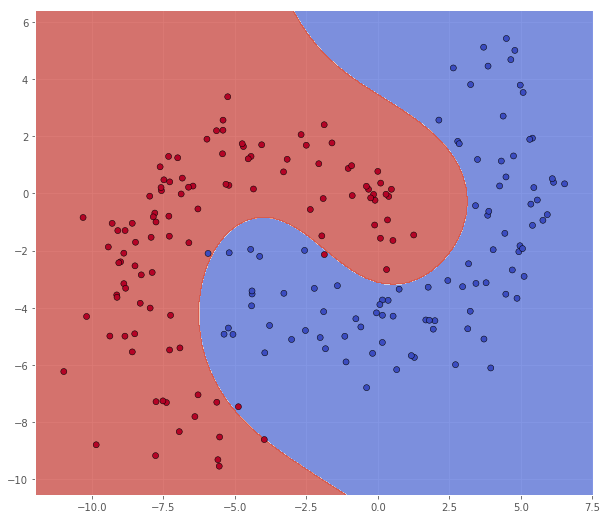

Metric name          Label 0  Label 1  Average
FN                      1.000    2.000    1.500
FP                      2.000    1.000    1.500
TN                    104.000   93.000   98.500
TP                     93.000  104.000   98.500
acc                     0.985    0.985    0.985
ppv                     0.979    0.990    0.985
tnr                     0.981    0.989    0.985
tpr                     0.989    0.981    0.985


In [30]:
X_train = bananadata['A']
Y_train = np.squeeze(bananadata['a'])

classifier = svm.SVC(C=128.0, kernel='rbf', gamma=0.0312)
classifier.fit(X_train, Y_train)

X_test = bananadata['B']
Y_test = np.squeeze(bananadata['b'])

xx, yy = make_meshgrid(X_test)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X_test, Y_test, xx, yy, Z)
pretty_print(evaluate(Y_test, classifier.predict(X_test)))

In this case it looks like we achieved quite a good result on the test set. For fun, lets try out with some of the other promising candidates, e.g. $C = 8$ and $\gamma = 0.5$.

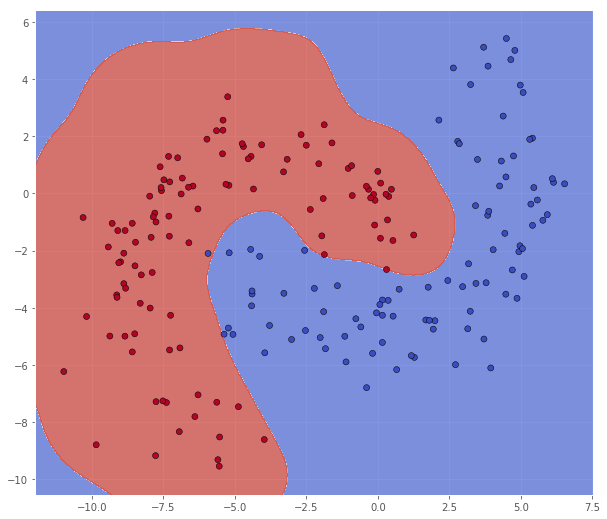

Metric name          Label 0  Label 1  Average
FN                      1.000    1.000    1.000
FP                      1.000    1.000    1.000
TN                    105.000   93.000   99.000
TP                     93.000  105.000   99.000
acc                     0.990    0.990    0.990
ppv                     0.989    0.991    0.990
tnr                     0.991    0.989    0.990
tpr                     0.989    0.991    0.990


In [31]:
classifier = svm.SVC(C=8.0, kernel='rbf', gamma=0.5)
classifier.fit(X_train, Y_train)

X_test = bananadata['B']
Y_test = np.squeeze(bananadata['b'])

xx, yy = make_meshgrid(X_test)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
scatter(X_test, Y_test, xx, yy, Z)
pretty_print(evaluate(Y_test, classifier.predict(X_test)))

This model actually performs better on the test set. This is something we often encounter in classification, and if we have enough data, it is common to have a hold-out validation set for hyperparameter optimization (in stead of cross-validation). But of course, we cannot have validation sets all the way down, so at some point we have to settle with some model. Inspired by this observation, it is not uncommon to train an ensamble of models (so called *ensamble learning*) and using some sort of average of the models in the classification.

#### Parameter grid search with cross-validation using sklearn

For more information, see `sklearn`'s page on
[corss-validation](http://scikit-learn.org/stable/modules/cross_validation.html) and 
[grid search](http://scikit-learn.org/stable/modules/grid_search.html). The code below is based on an example found [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py).

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)


parameters = [{'kernel': ['rbf'],
               'gamma': gamma_arr,
               'C': C_arr}]

metrics = ['accuracy', 'recall_macro']

for metric in metrics:
    print("# Tuning hyper-parameters for {}".format(metric))

    classifier = GridSearchCV(SVC(), parameters, cv=10, scoring=metric)
    classifier.fit(X_train, Y_train)

    print("\nBest parameter set found on training set:")
    print(classifier.best_params_)
    print("\nGrid scores on training set:")
    means = classifier.cv_results_['mean_test_score']
    stds = classifier.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, classifier.cv_results_['params']):
        print("{0:>7,.3f} (+/-{1:>7,.3f}) for {2}".format(mean, std * 2, params))

    print("\nDetailed classification report:")
    print("\nThe model is trained on the full training set.")
    print("The scores are computed on the full test set.")
    Y_true, Y_pred = Y_test, classifier.predict(X_test)
    print(classification_report(Y_true, Y_pred))

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for accuracy

Best parameter set found on training set:
{'gamma': 0.5, 'kernel': 'rbf', 'C': 0.125}

Grid scores on training set:
  0.890 (+/-  0.100) for {'gamma': 0.03125, 'kernel': 'rbf', 'C': 0.03125}
  0.865 (+/-  0.128) for {'gamma': 0.125, 'kernel': 'rbf', 'C': 0.03125}
  0.530 (+/-  0.020) for {'gamma': 0.5, 'kernel': 'rbf', 'C': 0.03125}
  0.530 (+/-  0.020) for {'gamma': 2.0, 'kernel': 'rbf', 'C': 0.03125}
  0.530 (+/-  0.020) for {'gamma': 8.0, 'kernel': 'rbf', 'C': 0.03125}
  0.530 (+/-  0.020) for {'gamma': 32.0, 'kernel': 'rbf', 'C': 0.03125}
  0.925 (+/-  0.095) for {'gamma': 0.03125, 'kernel': 'rbf', 'C': 0.125}
  0.980 (+/-  0.049) for {'gamma': 0.125, 'kernel': 'rbf', 'C': 0.125}
  0.995 (+/-  0.030) for {'gamma': 0.5, 'kernel': 'rbf', 'C': 0.125}
  0.530 (+/-  0.020) for {'gamma': 2.0, 'kernel': 'rbf', 'C': 0.125}
  0.530 (+/-  0.020) for {'gamma': 8.0, 'kernel': 'rbf', 'C': 0.

As is evident, me and sklearn did not end up with entirely the same results, but for this data (which is quite easy), the solution space near the solution is quite flat, so that is no surprise. There is also, obviously, the possibility that there are some bugs in my implementation.